In [190]:
import pandas as pd
import matplotlib.pyplot as pyplot
import os
from scipy.stats import ttest_ind

# 1. Plot daily sales for all 50 weeks.

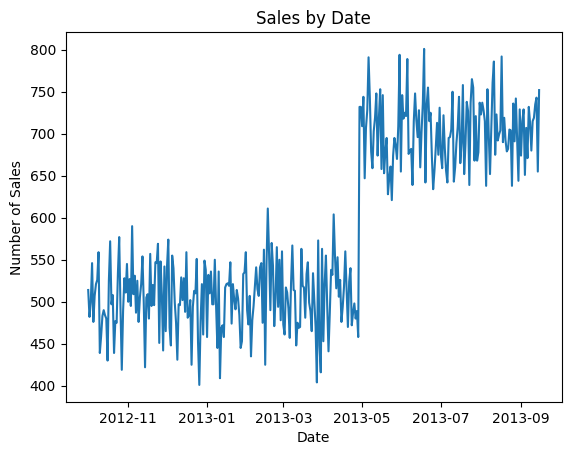

In [191]:
# Create daily sales as you parse through all the data 
# Loop through each file in directory
# For every file, create daily values and insert into some daily_df
# keep going until all data is parsed and then plot data

sales_files = os.listdir()[1:]
daily_sales = pd.DataFrame(columns=["Date","Daily Sales"])

for weekly_sales_file in sales_files:
    df = pd.read_csv(weekly_sales_file)
    df["sale_time"] = df["sale_time"].astype("datetime64[D]")
    daily_data = df.groupby("sale_time").count().reset_index()
    
    for row_pos in daily_data.index:
        daily_sales.loc[daily_sales.shape[0]] = list(daily_data.loc[row_pos])

pyplot.plot(daily_sales["Date"],daily_sales["Daily Sales"])
pyplot.title("Sales by Date")
pyplot.xlabel("Date")
pyplot.ylabel("Number of Sales")
pyplot.show()

# 2. It looks like there has been a sudden change in daily sales. What date did it occur?

In [192]:
# Looks like somewhere around May 2013, but hard to find the exact date from the picture
# Somewhere around May is when the sales spike up towards 700+. Can look for first occurence of that in the data
daily_sales["> 700?"] = daily_sales["Daily Sales"] > 700
daily_sales[daily_sales["> 700?"]].head(1)

# Date was April 29, 2013

,Date,Daily Sales,> 700?
210,2013-04-29,732,True


# 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [193]:
ttest_ind(daily_sales[daily_sales["Date"] < "2013-04-29"]["Daily Sales"],daily_sales[daily_sales["Date"] > "2013-04-29"]["Daily Sales"])

# abs(p-val) < 0.05, so the null hypothesis is rejected, therefore it is statsitically significant

Ttest_indResult(statistic=-45.609651041811304, pvalue=1.244094244501806e-148)

# 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

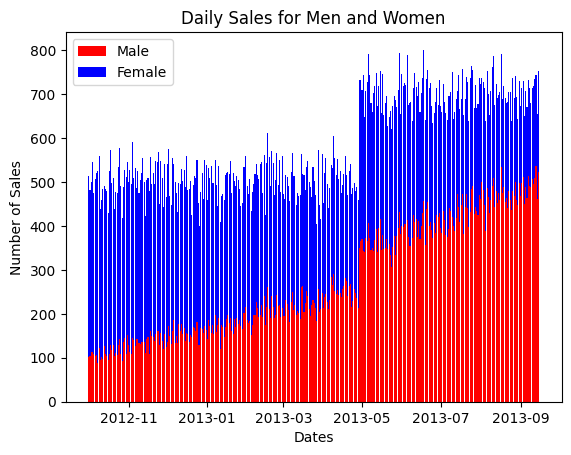

In [194]:
# So, need to pretty much do the same thing as Q1 but make sure there is a distinction between genders
# Original files only has datetime and gender, but for grouping to work, I need something to run a count on -> will call it "Count Value"

sales_files = os.listdir()[1:]
daily_sales_gender = pd.DataFrame(columns=["Date","Gender","Daily Sales"])

for weekly_sales_file in sales_files:
    df = pd.read_csv(weekly_sales_file)
    df["sale_time"] = df["sale_time"].astype("datetime64[D]")
    df["Count Value"] = 1
    daily_data_gender = df.groupby(["sale_time","purchaser_gender"]).count().reset_index()
    
    for row_pos in daily_data_gender.index:
        daily_sales_gender.loc[daily_sales_gender.shape[0]] = list(daily_data_gender.loc[row_pos])

# daily_sales_gender
male_sales = daily_sales_gender[daily_sales_gender["Gender"].str.startswith("m")]["Daily Sales"]
female_sales = daily_sales_gender[daily_sales_gender["Gender"].str.startswith("f")]["Daily Sales"]
dates = daily_sales_gender[daily_sales_gender["Gender"].str.startswith("f")]["Date"]

pyplot.bar(dates,male_sales,color="r")
pyplot.bar(dates,female_sales,color="b",bottom=male_sales)
pyplot.xlabel("Dates")
pyplot.ylabel("Number of Sales")
pyplot.legend(["Male","Female"])
pyplot.title("Daily Sales for Men and Women")
pyplot.show()

In [195]:
# Graph kind of works and I think its possible to see that men are taking a bigger proportion of the sales. However, it's hard to make that distinction around the jump in sales near May
# Can always work with percetanges instead so everything is scaled to 100. Trying that to see if it makes it better

# General Idea -> Might be off by a bit if I round
# 2012-10-01    Female  80.35019455252919
# 2012-10-01    Male    19.649805447470817

proportion_values = []

for elem in range(0,len(daily_sales_gender),2):
    female_sales = daily_sales_gender.iloc[elem]["Daily Sales"]
    male_sales = daily_sales_gender.iloc[elem+1]["Daily Sales"]
    male_proportion = round(male_sales/(male_sales + female_sales) * 100,2)
    female_proportion = round(female_sales/(male_sales + female_sales) * 100,2)
    proportion_values.append(female_proportion)
    proportion_values.append(male_proportion)
   
daily_sales_gender["Proportion"] = proportion_values
daily_sales_gender

,Date,Gender,Daily Sales,Proportion
0,2012-10-01,female,413,80.35
1,2012-10-01,male,101,19.65
2,2012-10-02,female,379,78.63
3,2012-10-02,male,103,21.37
4,2012-10-03,female,386,77.35
...,...,...,...,...
695,2013-09-13,male,537,72.27
696,2013-09-14,female,193,29.47
697,2013-09-14,male,462,70.53
698,2013-09-15,female,230,30.59


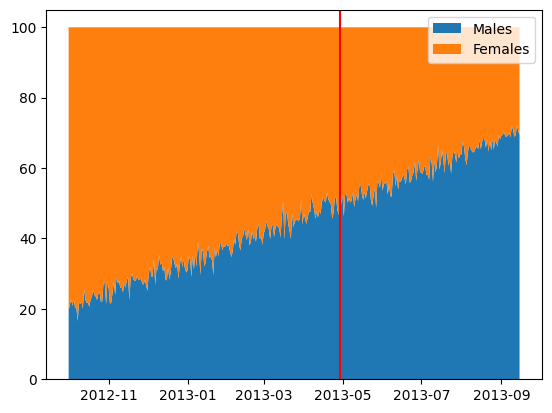

In [196]:
# Plotting it
male_proportion = daily_sales_gender[daily_sales_gender["Gender"].str.startswith("m")]["Proportion"]
female_proportion = daily_sales_gender[daily_sales_gender["Gender"].str.startswith("f")]["Proportion"]
date_of_inc_sales = daily_sales_gender[daily_sales_gender["Date"] == "2013-04-29"].head(1)["Date"]


pyplot.stackplot(dates,[male_proportion,female_proportion],labels=["Males","Females"])
pyplot.axvline(x=date_of_inc_sales,color="r")
pyplot.legend()
pyplot.show()


In [197]:
# Men are beginning to take a bigger proportion in sales than women over time, but there is no big shift around the jump in sales that occurs on April 29, 2013.

# 5. Assume a given day is divided into four dayparts:

    night (12:00AM - 6:00AM),
    morning (6:00AM - 12:00PM),
    afternoon (12:00PM - 6:00PM),
    evening (6:00PM - 12:00AM).

What is the percentage of sales in each daypart over all 50 weeks?

In [198]:
# Upon import, need to categorize and then figure out percentages. Will break up into two parts

# Categorize
#df = pd.read_csv("sales_week_starting_2012-10-01.csv")
#df["sale_time"].head(1).values[0][11:13]

# Probably can use dictionaries and loop to do it better, but this works well enough for this problem
def time_of_day(datetime_stamp):
    hour = int(datetime_stamp[11:13])
    if hour <= 6:
        return "Night"
    elif hour <= 12:
        return "Morning"
    elif hour <= 18:
        return "Afternoon"
    else:
        return "Evening"
    
sales_files = os.listdir()[1:]
full_weekly_sales = pd.DataFrame(columns=["sale_time","purchaser_gender"])
list_of_weekly_files = []

for weekly_sales_file in sales_files:
    df = pd.read_csv(weekly_sales_file)
    list_of_weekly_files.append(df)

full_weekly_sales = pd.concat(list_of_weekly_files)
full_weekly_sales["Time of Day"] = full_weekly_sales["sale_time"].apply(time_of_day)
full_weekly_sales["Counter"] = 1
full_weekly_sales["sale_time"] = full_weekly_sales["sale_time"].astype("datetime64[D]")
full_weekly_sales_grouped = full_weekly_sales.groupby(["sale_time","Time of Day"]).count()["Counter"].reset_index()
full_weekly_sales_grouped
    

,sale_time,Time of Day,Counter
0,2012-10-01,Afternoon,193
1,2012-10-01,Evening,82
2,2012-10-01,Morning,178
3,2012-10-01,Night,61
4,2012-10-02,Afternoon,187
...,...,...,...
1395,2013-09-14,Night,70
1396,2013-09-15,Afternoon,304
1397,2013-09-15,Evening,118
1398,2013-09-15,Morning,237


In [199]:
# Same idea as the male/female percentage calculation but now scaled up to 4 groupings
time_of_day_percentages = []

for elem in range(0,len(full_weekly_sales_grouped),4):
     afternoon_count = full_weekly_sales_grouped.iloc[elem]["Counter"]
     evening_count = full_weekly_sales_grouped.iloc[elem+1]["Counter"]
     morning_count = full_weekly_sales_grouped.iloc[elem+2]["Counter"]
     night_count = full_weekly_sales_grouped.iloc[elem+3]["Counter"]
     total = afternoon_count + evening_count + morning_count + night_count

     afternoon_percentage = round(afternoon_count/total * 100,2)
     evening_percentage = round(evening_count/total * 100,2)
     morning_percentage = round(morning_count/total * 100,2)
     night_percentage = round(night_count/total * 100,2)

     time_of_day_percentages.append(afternoon_percentage)
     time_of_day_percentages.append(evening_percentage)
     time_of_day_percentages.append(morning_percentage)
     time_of_day_percentages.append(night_percentage)

full_weekly_sales_grouped["Percentages"] = time_of_day_percentages
full_weekly_sales_grouped


,sale_time,Time of Day,Counter,Percentages
0,2012-10-01,Afternoon,193,37.55
1,2012-10-01,Evening,82,15.95
2,2012-10-01,Morning,178,34.63
3,2012-10-01,Night,61,11.87
4,2012-10-02,Afternoon,187,38.80
...,...,...,...,...
1395,2013-09-14,Night,70,10.69
1396,2013-09-15,Afternoon,304,40.43
1397,2013-09-15,Evening,118,15.69
1398,2013-09-15,Morning,237,31.52
